![](../logo.png)

# Linear regression
## Yoav Ram

Linear regression is a statistical method used to model the relationship between a dependent variable (response, target, $y$) and one or more independent variables (predictors, features, $x$) by fitting a linear equation to the observed data (ProbML ch. 11).

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import jax.numpy as np
import jax
from jax import random
from jax.scipy import stats, optimize
import pandas as pd
import seaborn as sns
sns.set(
    style='white',
    context='talk'
)
red, blue, green = sns.color_palette('Set1', 3)

# Normal linear model

We will use a linear model to describe the relationship between height and weight.
Height generally makes more sense as a predictor (x) because:

- Causality: Height is a structural trait that develops earlier and influences weight indirectly through factors like body size and composition.
- Biological Intuition: In most biological contexts, height is less variable than weight, and weight tends to scale with height.
- Application: Many models use height to estimate weight (e.g., body mass index calculations), aligning with common practices.

Denote the number of individuals by $n$.
We assume that the weight $y_i$ of individual $i$ is **normally distributed** an expected value $\hat{y}_i$, which is a linear function of his height, $x_i$,
$$
\hat{y}_i = a x_i + b $$$$
y_i \sim N(\hat{y}_i, \sigma^2)
$$
Here, $a$, $b$, and $\sigma$ are the model parameters, also called weights or coefficients.
- $a$ is the _slope_: the effect of an increase by one inch on the expected weight in pounds, $a = \mathbb{E}[\hat y(x+1) - \hat y(x)]$.
- $b$ is the _intercept_ - the expected weight for a hypothetical individual of height zero, $b= \mathbb{E}[\hat y(x)]$.

This is sometimes called **simple linear regression** as $x$ is one dimensional.

We start by simulating data before using real data.

In [2]:
key = random.key(2889) # generate a random number key

# additional pounds per inch
a = 2
# calculate b from typical newborn height of 20 inch and weight of 7 pounds 
b = 7 - 20*a
# number of measurements
n = 200 
# generate measurements
key, subkey = random.split(key)
X = 70 + 2 * random.normal(subkey, shape=(n,))
key, subkey = random.split(key)
Y = a * X + b + 3 * random.normal(subkey, shape=(n,))

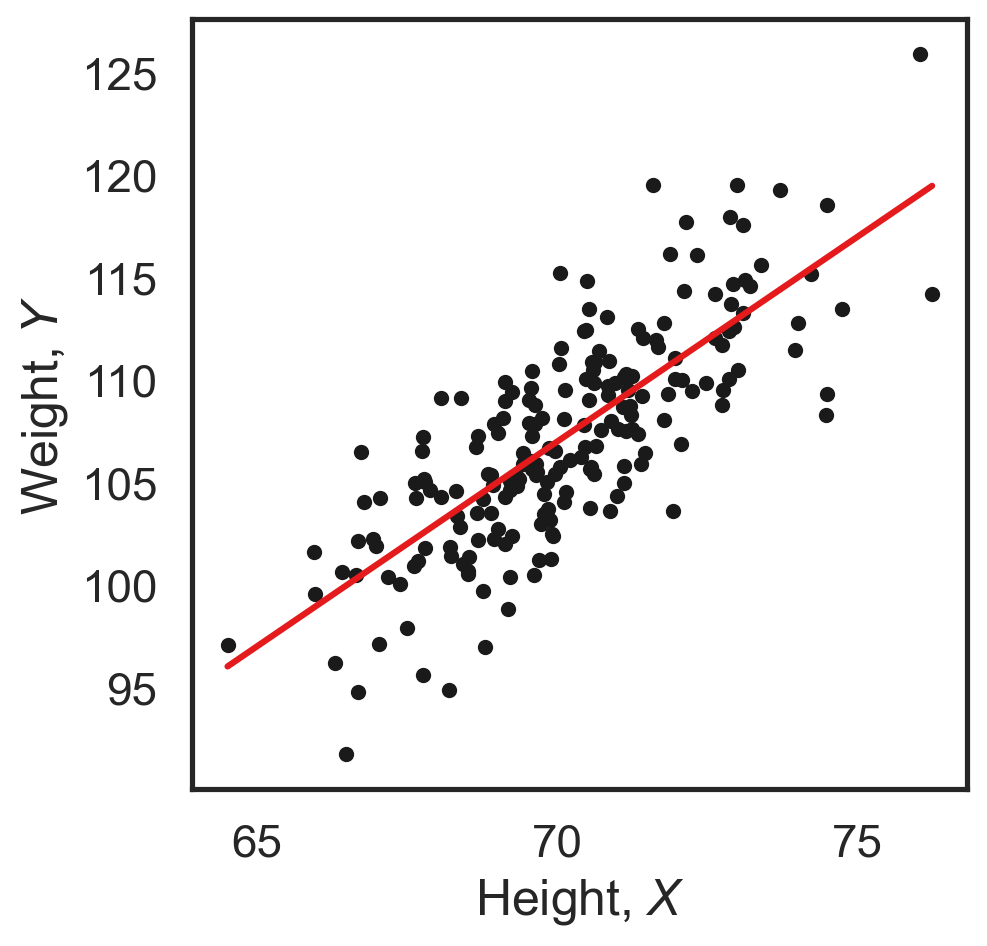

In [3]:
plt.figure(figsize=(5, 5))
plt.plot(X, Y, '.k')
x_range = np.linspace(X.min(), X.max())
plt.plot(x_range, a * x_range + b, color=red)
plt.xlabel("Height, $X$")
plt.ylabel("Weight, $Y$");

# Maximum likelihood estimation

From our model, the likelihood is
$$
p(y_i \mid x_i, a, b, \sigma^2) = \frac{1}{\sqrt{2\pi \sigma^2}}\exp{\left(-\frac{(y_i-\hat{y}_i)^2}{2\sigma^2}\right)}
$$
and assuming $\{y_i | x_i\}_{i=1}^{n}$ are independent, 
$$
p(Y \mid X, a, b, \sigma^2) = 
\prod_{i=1}^{n}{\frac{1}{\sqrt{2\pi \sigma^2}} \exp{\left(-\frac{(y_i-\hat{y}_i)^2}{2\sigma^2}\right)}}
$$
where $X=(x_1, \ldots, x_n)$ and $Y=(y_1, \ldots, y_n)$.

Therefore, the negative log likelihood is
$$
NLL(a,b,\sigma^2) = -\log\left[\prod_{i=1}^{n}{\frac{1}{\sqrt{2\pi \sigma^2}} \exp{\left(-\frac{(y_i-\hat{y}_i)^2}{2\sigma^2}\right)}} \right] = $$$$
\frac{n}{2} \log(2 \pi \sigma^2) + \frac{1}{2\sigma^2} \sum_{i=1}^{n}{(y_i-\hat{y}_i)^2 }
$$

In principle, we can minizime for $a$, $b$, and $\sigma$, but in many cases we don't really care about $\sigma$ and therefore we focus on $a$ and $b$, which reduces the problem to minimizing the **residual sum of squares**,
$$
RSS(a, b) = \frac{1}{2}\sum_{i=1}^{n}{(y_i-\hat{y}_i)^2 } = $$$$
\frac{1}{2}\sum_{i=1}^{n}{y_i^2-2y_i\hat{y}_i+\hat{y}_i^2 } = 
\frac{1}{2}\sum_{i=1}^{n}{y_i^2-2y_i(ax_i+b)+(ax_i+b)^2 }
$$
Hence, this technique is usually **ordinary least squares** or just *leastsq*.

In [4]:
def RSS(θ, X, Y):
    a, b = θ
    X = X.reshape((-1, 1)) # when θ is shape (m, 2)
    Yhat = a * X + b
    residuals = (Y - Yhat)
    return 0.5 * (residuals * residuals).sum()

print(RSS((a,b), X, Y))

878637.94


Taking derivatives with respect to $a$ and $b$,
$$
\frac{\partial RSS}{\partial a} = \sum_{i=1}^{n}{ax^2_i +bx_i -x_i y_i} $$$$
\frac{\partial RSS}{\partial b} = \sum_{i=1}^{n}{ax_i +b -y_i}
$$
Solving for $\frac{\partial RSS}{\partial a}=\frac{\partial RSS}{\partial b}=0$, we have
$$
\sum_{i=1}^{n}{ax^2_i +bx_i} = \sum_{i=1}^{n}{x_i y_i} $$$$
\sum_{i=1}^{n}{ax_i +b} = \sum_{i=1}^{n}{y_i}
$$
and the solution is given by
$$
\hat a = \frac{\sum_{i=1}^{n}{(x_i - \bar{x})(y_i - \bar{y})}}{\sum_{i=1}^{n}{(x_i - \bar{x})^2}} $$$$
\hat b = \bar{y} - \hat{a} \bar{x}
$$

In [5]:
def mle(X, Y):
    a_hat = ((X - X.mean()) * (Y - Y.mean())).sum() / ((X - X.mean())**2).sum()
    b_hat = Y.mean() - a_hat * X.mean()
    return (a_hat, b_hat)

a_hat, b_hat = mle(X, Y)
print("a* = {:4.2f} \t a_hat = {:4.2f}".format(a, a_hat))
print("b* = {:4.2f} \t b_hat = {:4.2f}".format(b, b_hat))

a* = 2.00 	 a_hat = 2.02
b* = -33.00 	 b_hat = -34.26


Let's visualize the result and compare to the true linear function.

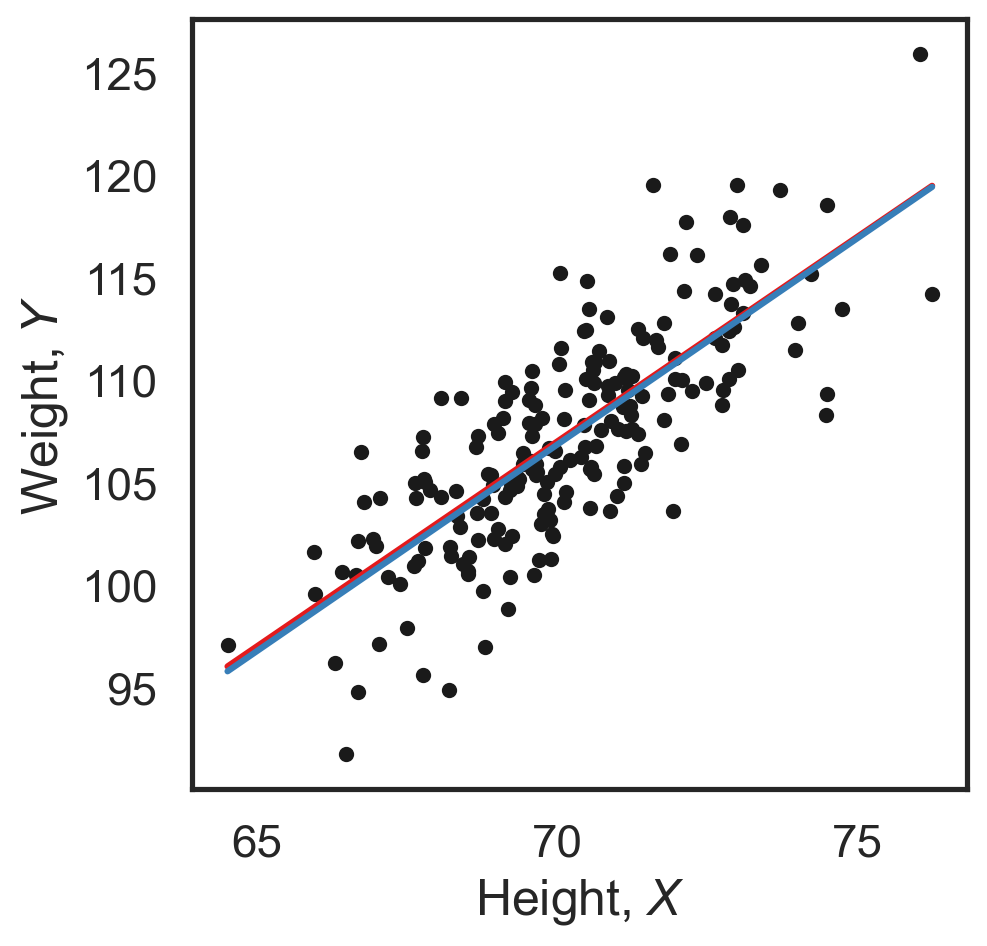

In [6]:
plt.figure(figsize=(5, 5))
plt.plot(X, Y, '.k')
x_range = np.linspace(X.min(), X.max())
plt.plot(x_range, a * x_range + b, color=red)
plt.plot(x_range, a_hat * x_range + b_hat, color=blue);
plt.xlabel("Height, $X$")
plt.ylabel("Weight, $Y$");

# Diagnostics
How well does the model fit the data?
We can plot a **residual plot** of $y_i-\hat{y}_i$ vs. $x_i$.
The model assumes $y_i \sim N(\hat{y_i}, \sigma^2)$, which is equivalent to $y_i-\hat{y}_i \sim N(0, \sigma^2)$.
Therefore, in the residual plot, the points should be symetric around zero.

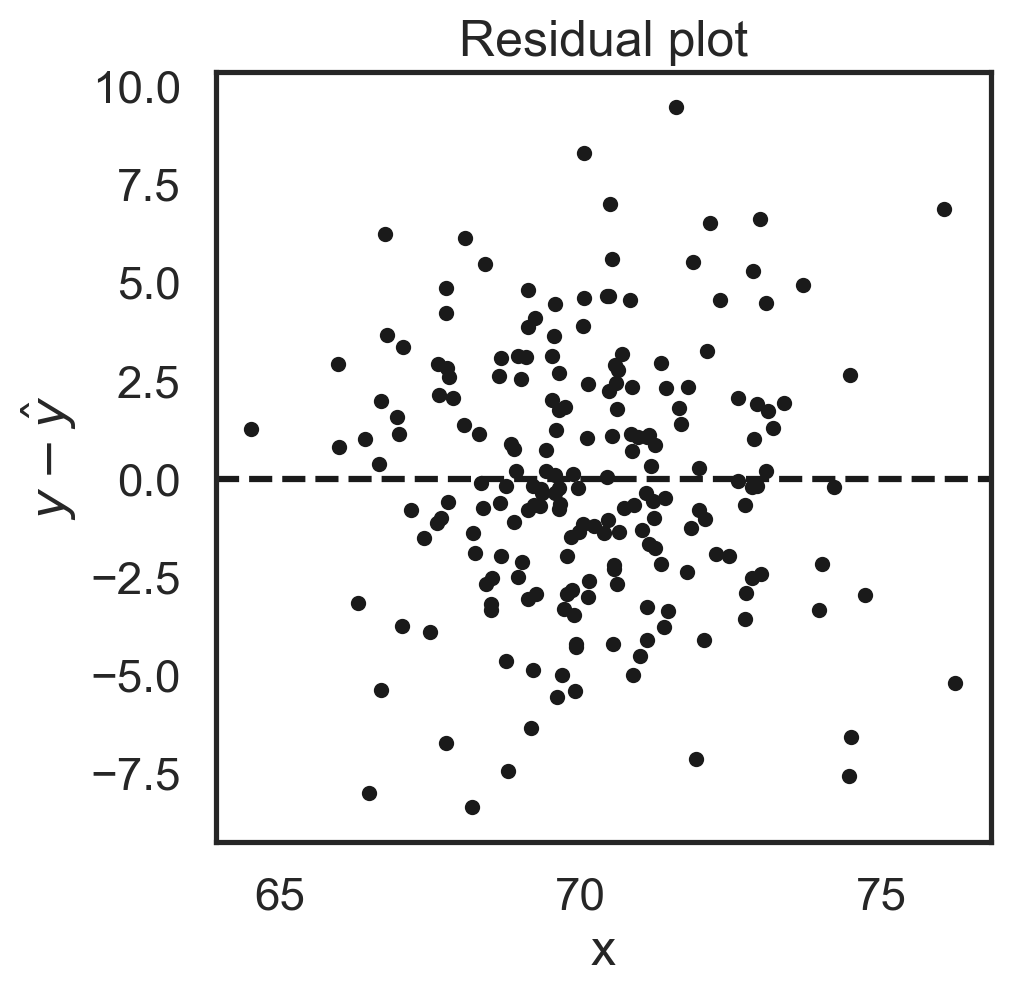

In [9]:
Y_hat = a_hat * X + b_hat
residuals = Y - Y_hat

plt.figure(figsize=(5, 5))
plt.plot(X, residuals, '.k')
plt.axhline(0, ls='--', color='k')
plt.title('Residual plot')
plt.xlabel(r'x')
plt.ylabel(r'$y-\hat{y}$');

We can also look at the **prediction error plot**, which compares $y_i$ to $\hat{y}_i$.

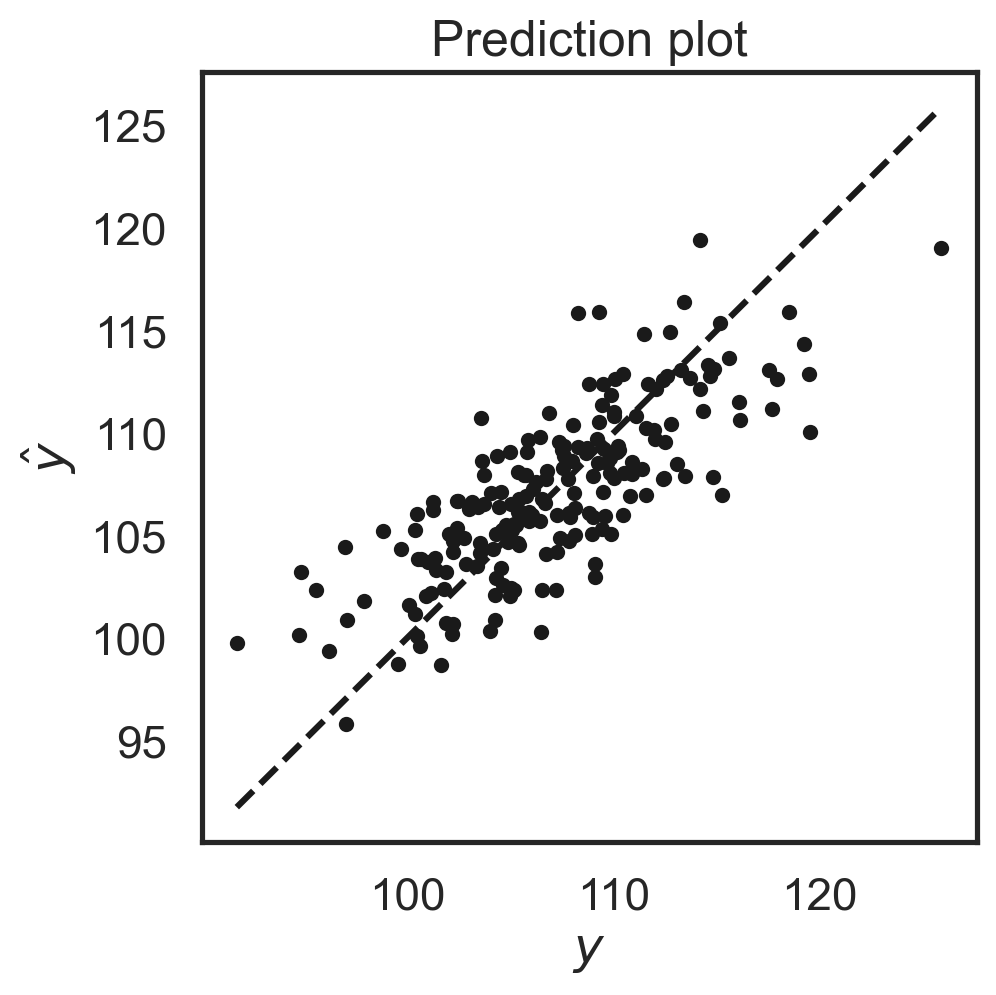

In [8]:
plt.figure(figsize=(5, 5))
plt.plot(Y, Y_hat, '.k')
y_range = np.linspace(Y.min(), Y.max())
plt.plot(y_range, y_range, '--k')
plt.title('Prediction plot')
plt.xlabel(r'$y$')
plt.ylabel(r'$\hat{y}$');

In many cases it may seem that the model over-estimates low $y_i$ values and under-estimates high $y_i$ values.
This occurs even when the model is correct (as in our case) due to noise in $y_i$: predictions are closer to the mean, especially for extreme values.
Remember that we minimized the sum of squared residuals, so extreme observations (with higher residuals) are pulled closer to the mean because this minimizes the overall error.

The RSS itself (and it's cousin, the RMSE, or root mean squared error: $\sqrt{\frac{1}{n}RSS}$), measure how well the model fits the data, but they are hard to interpret, as most measures based on likelihood are. They are mostly used as relative measures.

Instead, a more interpretable measure is the **coefficient of determination**, $R^2$,
$$
R^2 \coloneqq  1 - \frac{\text{RSS}}{\text{TSS}} = 1 - \frac{1}{2}\frac{\sum_{i=1}^{n}{(\hat{y}_i - y_i)^2}}{\frac{1}{2}\sum_{i=1}^{n}{(\bar{y} - y_i)^2}}
$$
where $\bar{y}=\frac{1}{n}\sum_{i=1}^{n}{y_i}$ is the empircial mean of the target, $\text{RSS}$ is the residual sum of squares (as above), and $\text{TSS}$ is the total sum of squares. This can be thought of as measuring the relative difference between the model RSS and the RSS of a naive model that just uses the empirical mean as prediction (i.e., disregarding $X$).

A model that is as good as a naive model will have $R^2=0$. A perfect model will have have zero RSS and therefore $R^2=1$.

In [10]:
def R2(Y, Y_hat):
    RSS = ((Y_hat - Y)**2).sum()
    TSS = ((Y.mean() - Y)**2).sum()
    return 1 - RSS / TSS
print('R2 = {:.4f}'.format(R2(Y, a_hat * X + b_hat)))

R2 = 0.6030


This is a good value of $R^2$.

Of course, this will really depend on the amount of noise, let's see this.

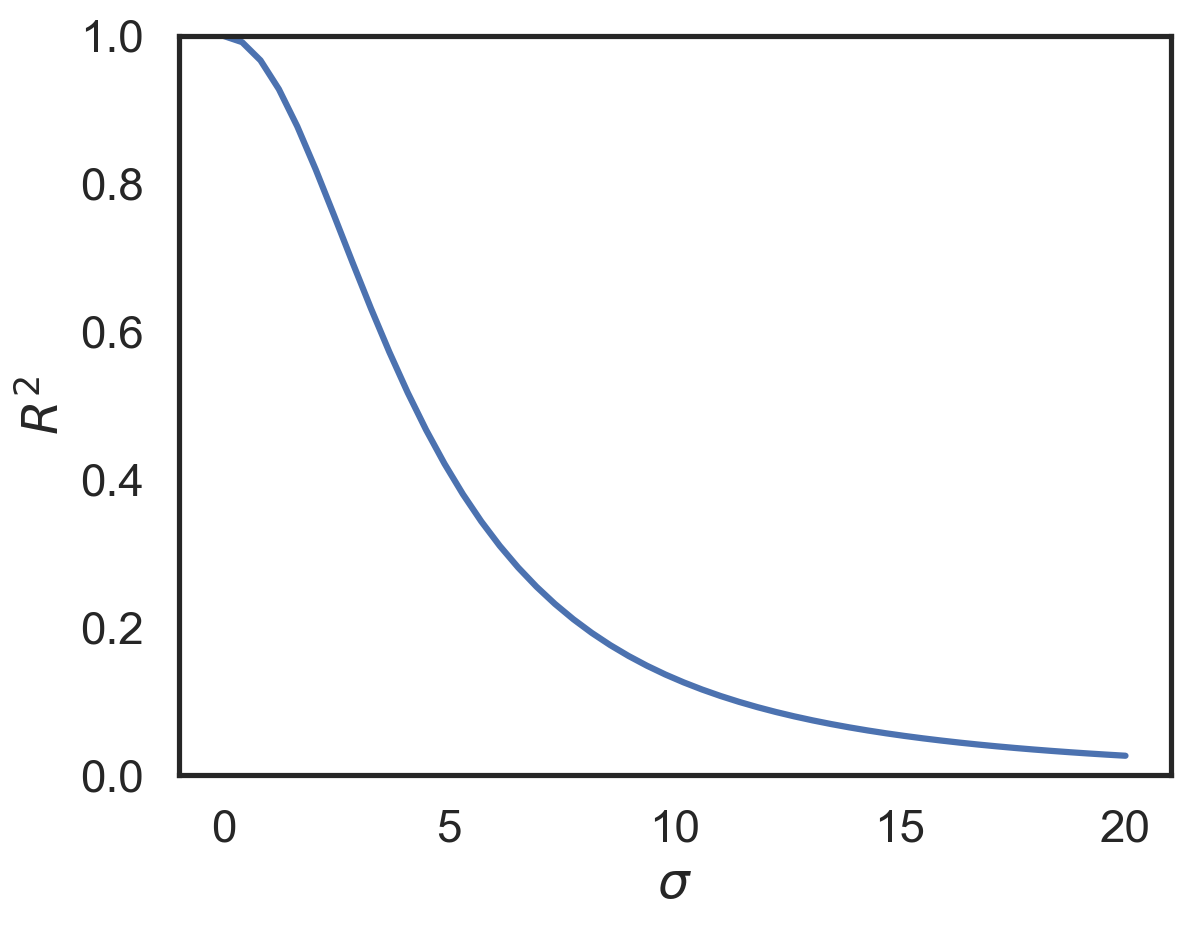

In [11]:
@jax.vmap
def noise_to_R2(ϵ):    
    Y = a * X + b + ϵ
    a_hat, b_hat = mle(X, Y)
    return R2(Y, a_hat * X + b_hat)

σs = np.linspace(0, 20)
key, subkey = random.split(key)
R2s = noise_to_R2(random.normal(subkey, shape=(n,)) * σs.reshape((-1, 1))) 
plt.plot(σs, R2s)
plt.xlabel(r'$\sigma$')
plt.ylabel(r'$R^2$')
plt.ylim(0, 1);

## RSS surface

We can also view our solution on the RSS surface.

In [12]:
a_range = np.linspace(1.0, 5.0)
b_range = np.linspace(-200.0, 0.0)
θ_range = np.array(np.meshgrid(a_range, b_range, indexing='ij'))

In [13]:
vmap_RSS = jax.vmap( # vmap makes this much faster than nested for loops
    jax.vmap(RSS, in_axes=(1, None, None)),
    in_axes=(2, None, None)
)
rsss = vmap_RSS(θ_range, X, Y)

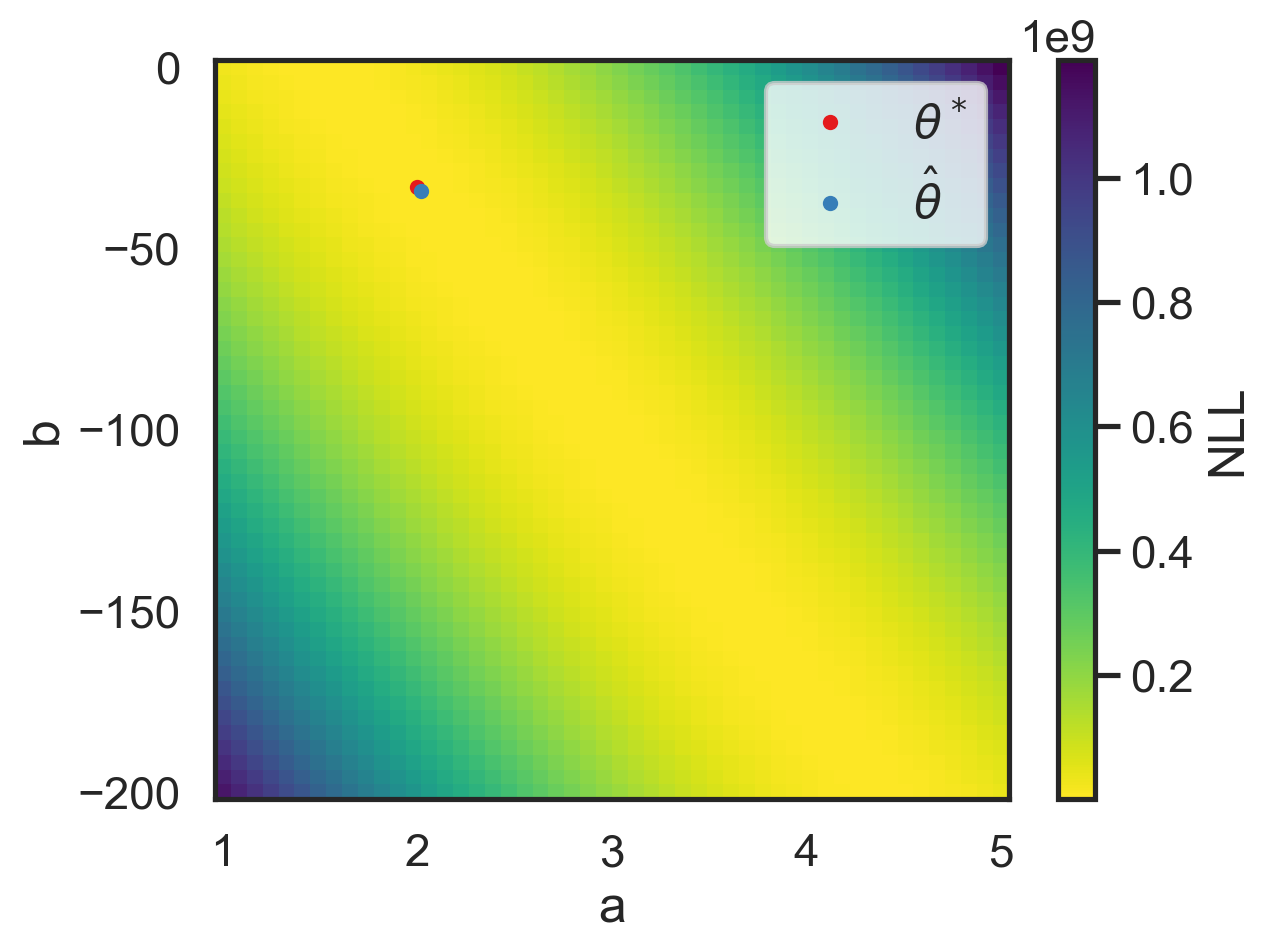

In [14]:
im = plt.pcolormesh(a_range, b_range, rsss, cmap='viridis_r')
plt.colorbar(im, label='NLL')
plt.plot(a, b, '.', color=red, label=r'$\theta^*$')
plt.plot(a_hat, b_hat, '.', color=blue, label=r'$\hat\theta$')
plt.legend()
plt.xlabel('a')
plt.ylabel('b');

So we see that in this case the estimate and the truth are very close!

# Application to real data

We now load some real height-weight data and attempt to perform MLE.

In [15]:
df = pd.read_csv('../data/height_weight_data.csv', index_col='Index')
df.columns = df.columns.str.strip()
X = df['Height (Inches)'].values
Y = df['Weight (Pounds)'].values

a_hat = 3.43
b_hat = -106.03
RSS(θ_hat) = 3729829.5600


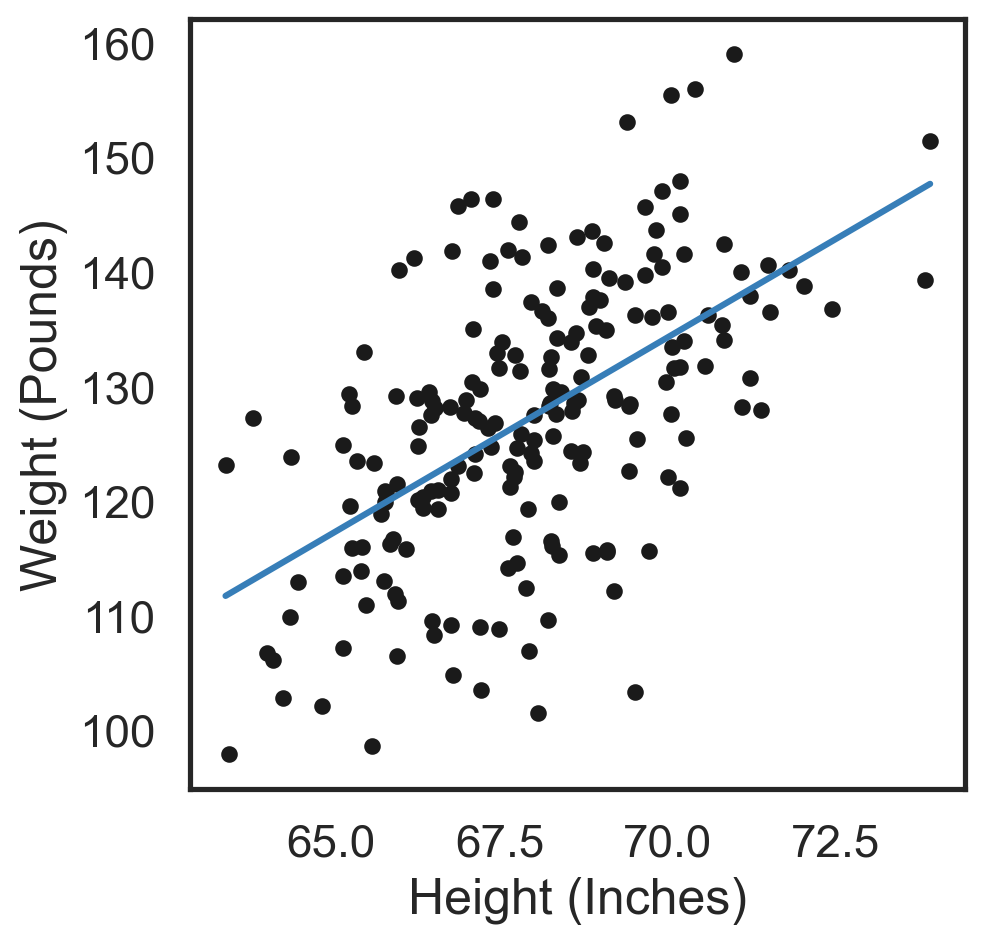

In [16]:
a_hat, b_hat = mle(X, Y)
print("a_hat = {:4.2f}".format(a_hat))
print("b_hat = {:4.2f}".format(b_hat))
print("RSS(θ_hat) = {:.4f}".format(RSS((a_hat, b_hat), X, Y)))

df.plot.scatter('Height (Inches)', 'Weight (Pounds)', color='k', figsize=(5, 5))
x_range = np.linspace(X.min(), X.max())
plt.plot(x_range, a_hat * x_range + b_hat, color=blue);

R2 = 0.3101


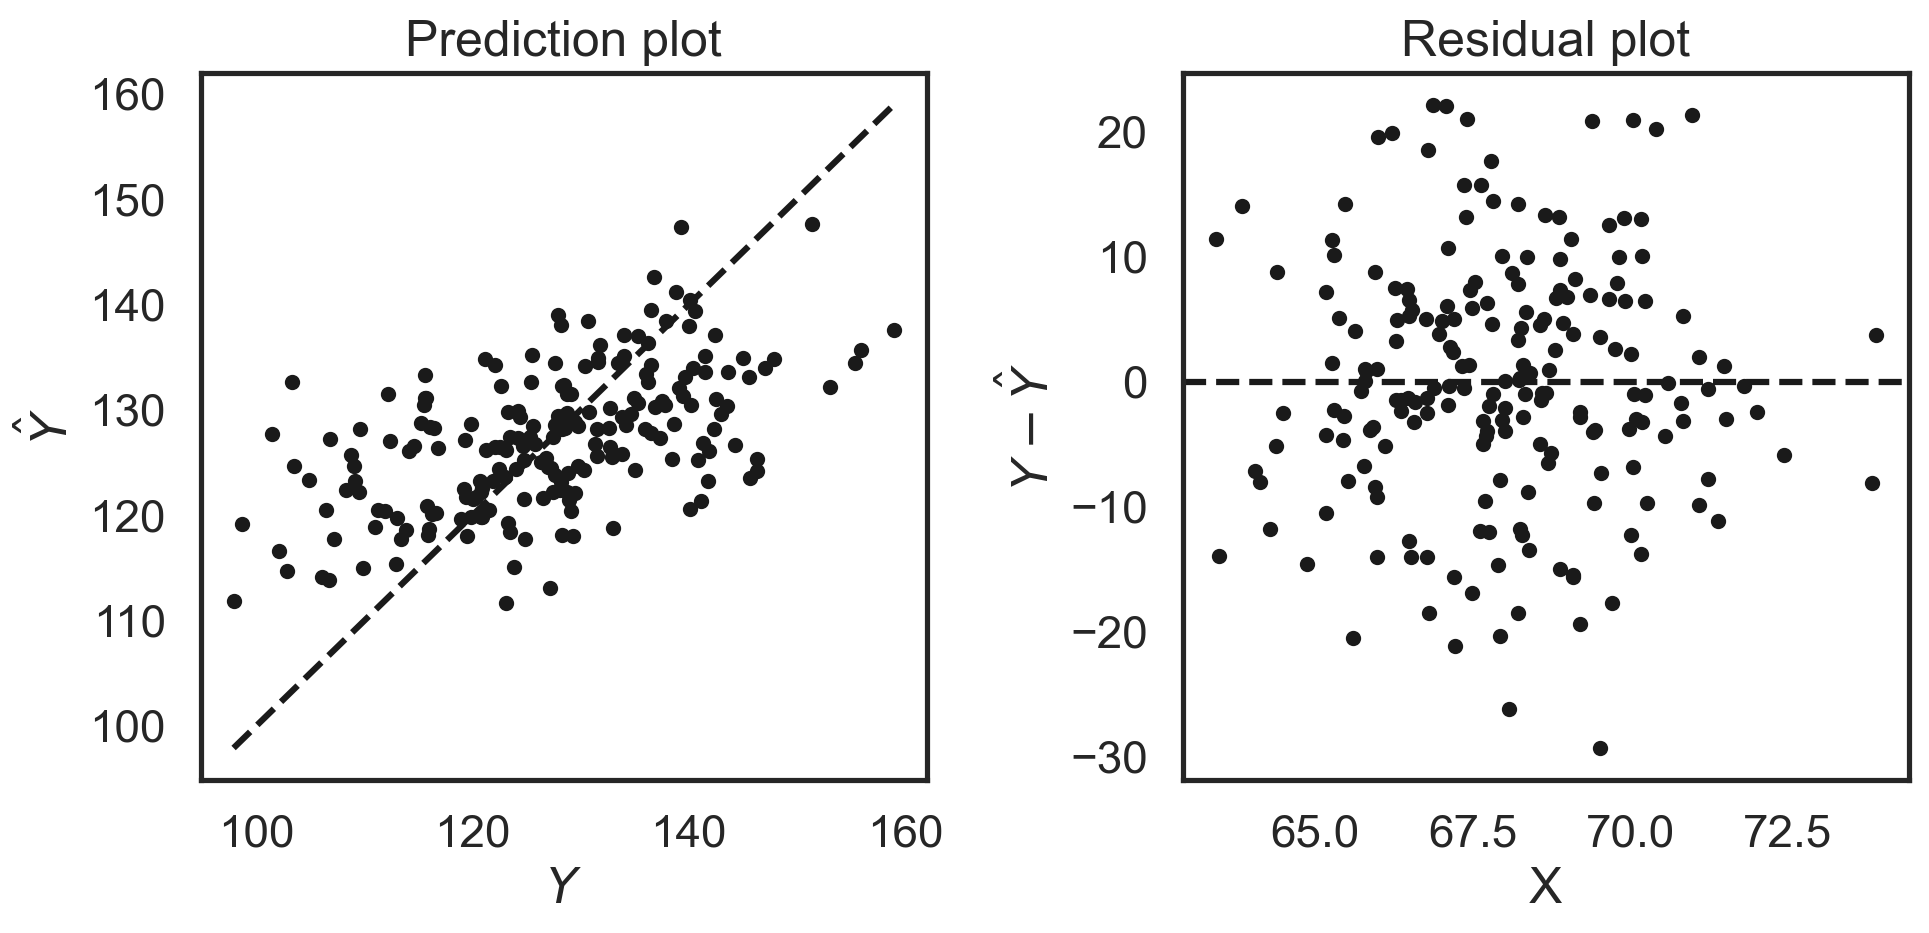

In [17]:
Y_hat = a_hat * X + b_hat
print('R2 = {:.4f}'.format(R2(Y, Y_hat)))
residuals = Y - Y_hat

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].plot(Y, Y_hat, '.k')
y_range = np.linspace(Y.min(), Y.max())
axes[0].plot(y_range, y_range, '--k')
axes[0].set_title('Prediction plot')
axes[0].set_xlabel(r'$Y$')
axes[0].set_ylabel(r'$\hat{Y}$');

axes[1].plot(X, residuals, '.k')
axes[1].axhline(0, ls='--', color='k')
axes[1].set_title('Residual plot')
axes[1].set_xlabel(r'X')
axes[1].set_ylabel(r'$Y-\hat{Y}$')

fig.tight_layout()

# Python packages implementing linear regression

## NumPy

NumPy's `polyfit` which fits a polynomial of specified degree to the data; in this case we want degree one. It returns the coefficients of the polynomial, which we could feed to `np.poly1d` to create a callable polynomial object.

In [18]:
a_np, b_np = np.polyfit(X, Y, 1)
print('a = {:.4f}, b = {:.4f}'.format(a_np, b_np))

a = 3.4327, b = -106.0278


## SciPy
`scipy.stats` module has a linear regression method, which basically uses the same method `polyfit` does (i.e. exact same result) but then also calculates some statistics.

In [19]:
import scipy.stats

result = scipy.stats.linregress(X, Y)
print('a = {:.4f}, b = {:.4f}'.format(result.slope, result.intercept))
print('R2 = {:.4f}'.format(result.rvalue**2))

a = 3.4327, b = -106.0277
R2 = 0.3101


# Statsmodels

This package focuses on statistical modeling, and as such, provides a full statistical analysis of the linear model.

Note that here `Y` comes before `X` and that in order to model the intercept we need to add a dummy variable of 1s to `X`.

In [20]:
import statsmodels.api as sm

In [22]:
X_ = sm.add_constant(X) # for intercept
Y = Y.tolist() # from jax array to list
result = sm.OLS(Y, X_).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.310
Model:                            OLS   Adj. R-squared:                  0.307
Method:                 Least Squares   F-statistic:                     89.00
Date:                Thu, 03 Apr 2025   Prob (F-statistic):           1.10e-17
Time:                        14:56:00   Log-Likelihood:                -742.50
No. Observations:                 200   AIC:                             1489.
Df Residuals:                     198   BIC:                             1496.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -106.0277     24.735     -4.287      0.000    -154.805     -57.250
x1             3.4327      0.364      9.434      0.000       2.715       4.150
==============================================================================
Omnibus:                        0.229   Durbin-Watson:                   2.021
Prob(Omnibus):                  0.892   Jarque-Bera (JB):                0.199
Skew:                          -0.076   Prob(JB):                        0.905
Kurtosis:                       2.971   Cond. No.                     2.39e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.39e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# References

- ProbML - [Probabilistic Machine Learning: An Introduction](https://probml.github.io/pml-book/book1.html) by Kevin P. Murphy. Online version. June 26, 2024
- Pawitan Y, 2001. *In all likelihood: statistical modelling and inference using likelihood*. **Ch. 6.1**.
- Animations of linear regression are available at [Seeing Theory](https://seeing-theory.brown.edu/regression-analysis/index.html#section1).

# Colophon
This notebook was written by [Yoav Ram](http://www.yoavram.com).

This work is licensed under a CC BY-NC-SA 4.0 International License.